In [55]:
import pandas as pd

# Load dataset (assuming it's a CSV file with weekly data)
df = pd.read_csv("data/MMM_data.csv")  # contains columns: DATE, revenue, tv_S, ooh_S, print_S, facebook_I, search_clicks_P, search_S, competitor_sales_B, facebook_S, events, newsletter
# Convert DATE to datetime and sort by date
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').set_index('DATE')
# Quick check for missing values
print(df.isnull().sum())
# Separate target and features
y = df['revenue']          # sales revenue (target)
X = df.drop(columns=['revenue'])


revenue               0
tv_S                  0
ooh_S                 0
print_S               0
facebook_I            0
search_clicks_P       0
search_S              0
competitor_sales_B    0
facebook_S            0
events                0
newsletter            0
dtype: int64


# Feature Engineering

## Lag features and moving averages

## Adstock transformation



In [56]:
# Create a 1-week lag of sales as a feature
X['lag1_revenue'] = y.shift(1)
# 4-week moving average of sales (to capture trend/seasonality)
X['MA4_revenue'] = y.rolling(window=4, min_periods=1).mean()

# Define adstock transformation function
def adstock(series, alpha=0.5):
    result = []
    carry = 0.0
    for val in series:
        carry = val + alpha * carry
        result.append(carry)
    return pd.Series(result, index=series.index)

# Apply adstock to each ad spend channel
for col in ['tv_S','ooh_S','print_S','facebook_S','search_S']:
    X[f'{col}_adstock'] = adstock(X[col], alpha=0.5)

# Drop original spend columns (and related exposure columns) now that we have adstock
X.drop(columns=['tv_S','ooh_S','print_S','facebook_S','facebook_I','search_S','search_clicks_P','events'], inplace=True)

# Align features and target (drop the first row due to lag)
X = X.iloc[1:]
y = y.iloc[1:]
print(X.columns)

Index(['competitor_sales_B', 'newsletter', 'lag1_revenue', 'MA4_revenue',
       'tv_S_adstock', 'ooh_S_adstock', 'print_S_adstock',
       'facebook_S_adstock', 'search_S_adstock'],
      dtype='object')


# Model Training


In [57]:
# Split into training and testing sets (train: 2016-2018, test: 2019)
train_X = X[:'2018-12-31']
train_y = y[:'2018-12-31']
test_X  = X['2019-01-01':]
test_y  = y['2019-01-01':]
print(f"Train samples: {len(train_X)}, Test samples: {len(test_X)}")

# Train an XGBoost Regression model
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=1)
model.fit(train_X, train_y)

Train samples: 162, Test samples: 45


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

# Model Evaluation

In [58]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Compute metrics
train_rmse = mean_squared_error(train_y, train_pred)
test_rmse = mean_squared_error(test_y, test_pred)
train_r2 = r2_score(train_y, train_pred)
test_r2 = r2_score(test_y, test_pred)

print(f"Train RMSE = {train_rmse:.0f},  R² = {train_r2:.3f}")
print(f"Test  RMSE = {test_rmse:.0f},  R² = {test_r2:.3f}")


Train RMSE = 39051998,  R² = 1.000
Test  RMSE = 50093113570,  R² = 0.886


In [59]:
# Compare sample actual vs predicted sales in test set
for date, actual, pred in list(zip(test_y.index, test_y, test_pred))[:5]:
    print(f"{date.date()}  actual={actual:.0f},  predicted={pred:.0f}")


2019-01-07  actual=2566165,  predicted=2679471
2019-01-14  actual=2554828,  predicted=2725623
2019-01-21  actual=1959707,  predicted=2015990
2019-01-28  actual=2424487,  predicted=2285588
2019-02-04  actual=1953060,  predicted=1964276


In [62]:
# Feature importance (by gain)
importance = model.get_booster().get_score(importance_type='gain')
# Include any feature with zero importance
for feat in train_X.columns:
    importance.setdefault(feat, 0.0)
# Sort by importance
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
for feat, score in importance:
    print(f"{feat}: {score:.2e}")


competitor_sales_B: 4.68e+11
MA4_revenue: 2.64e+11
tv_S_adstock: 4.36e+10
facebook_S_adstock: 1.90e+10
lag1_revenue: 1.86e+10
ooh_S_adstock: 1.26e+10
search_S_adstock: 6.48e+09
print_S_adstock: 3.65e+09
newsletter: 1.94e+09


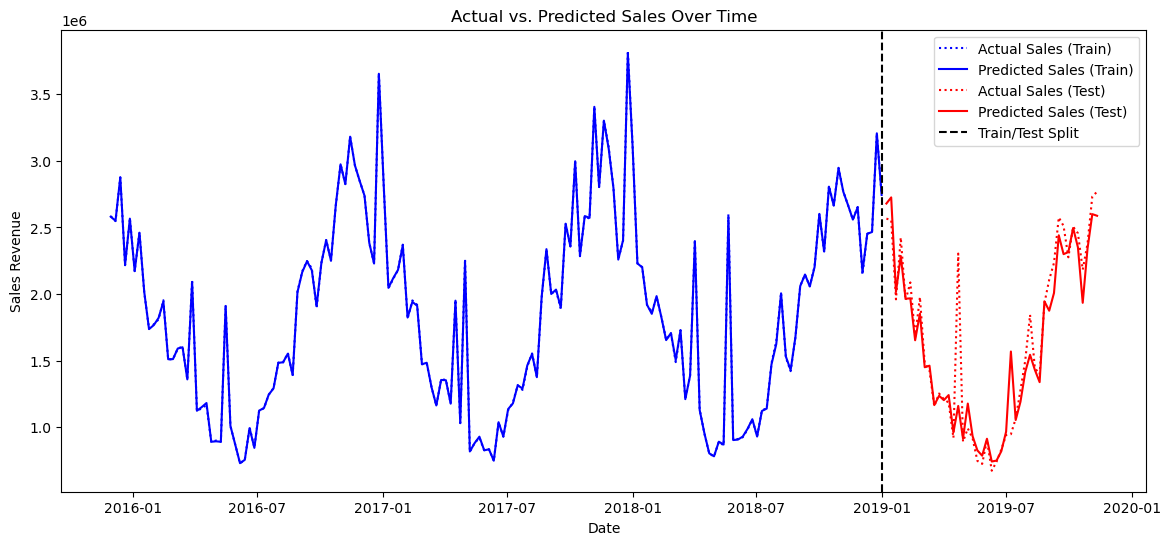

In [60]:
import matplotlib.pyplot as plt

# Plot actual vs predicted sales
plt.figure(figsize=(14, 6))
plt.plot(train_y.index, train_y, label="Actual Sales (Train)", color='blue', linestyle='dotted')
plt.plot(train_y.index, train_pred, label="Predicted Sales (Train)", color='blue')
plt.plot(test_y.index, test_y, label="Actual Sales (Test)", color='red', linestyle='dotted')
plt.plot(test_y.index, test_pred, label="Predicted Sales (Test)", color='red')

plt.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.title("Actual vs. Predicted Sales Over Time")
plt.legend()
plt.show()


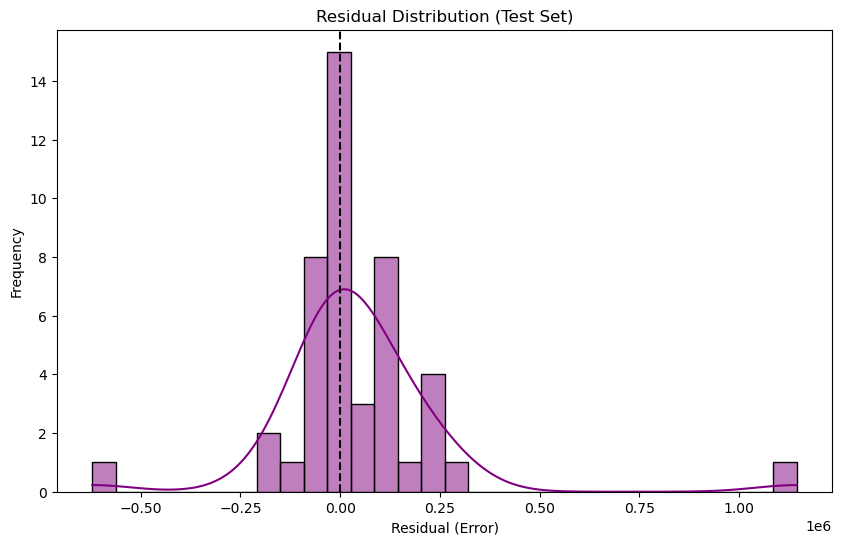

In [61]:
import seaborn as sns

residuals = test_y - test_pred  # Calculate residuals (actual - predicted)

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Test Set)")
plt.show()


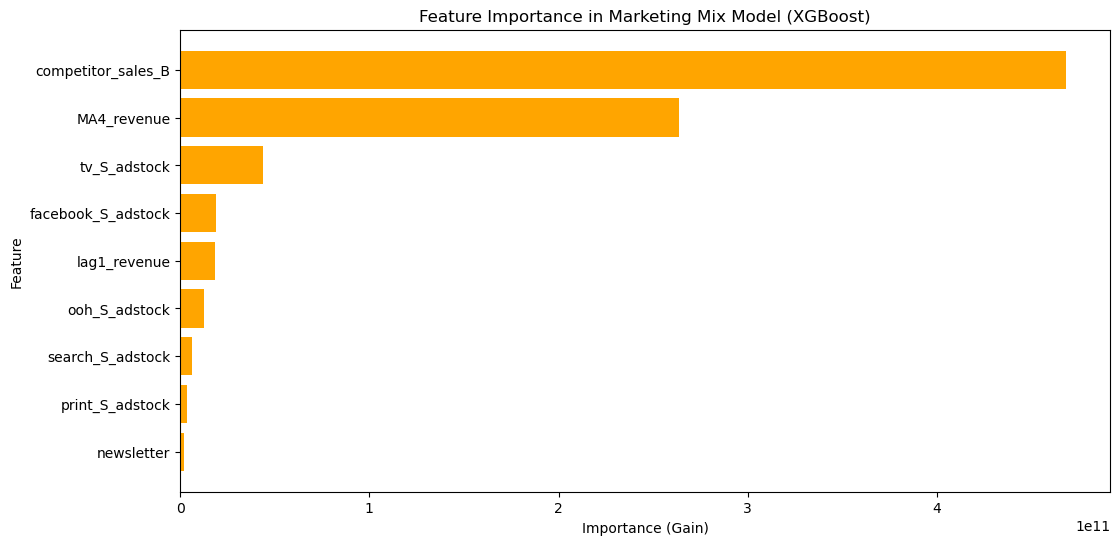

In [63]:
# Convert feature importance to DataFrame
importance_df = pd.DataFrame(importance, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="orange")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("Feature Importance in Marketing Mix Model (XGBoost)")
plt.show()
